#### W pierwszej kolejności pobieram dane z Kaggle odnoszące się do danych marketingowych 
https://www.kaggle.com/datasets/volodymyrgavrysh/bank-marketing-campaigns-dataset

In [1]:
import pandas as pd
import numpy as np
import os

data_path = r"E:\page_ds\tweaking_the_response_results"

dane = pd.read_csv(os.path.join(data_path, "bank-additional-full.csv"), sep=';')

In [ ]:
# przyglądnę się danym i ewentualnie zredukuję listę zmiennych
from dataprep.eda import create_report

report = create_report(dane, title='EDA dla kampanii marketingowej')
# przenoszę do przeglądarki
report.save(os.path.join(data_path, "EDA_dla_kampanii.html"))
report.show_browser()
report.show()

#### Akcje:
1. kodujemy _pdays_ na wartości 1 - gdy =999, 0 w przeciwnym wypadku
2. OHE dla zmiennych tekstowych
3. wywalam zmienne silnie skorelowane - emp.var.rate, euribor3m
4. month - wydaje się popsuta
5. duration - jest sugestia żeby nie dawac do modelu - zbyt silna zależnośc do y (brak kontaktu -> = 0 )
6. dokonuję próbkowania próbując zbalansować próbkę danych, która jest dość mocno niezbalansowana 

In [2]:
# kolumny numeryczne
dane._get_numeric_data().columns.difference(['pdays','emp.var.rate','euribor3m','duration']).tolist()

['age',
 'campaign',
 'cons.conf.idx',
 'cons.price.idx',
 'nr.employed',
 'previous']

In [3]:
# kolumny 
dane.select_dtypes(include=['object']).columns.difference(['y']).tolist()

['contact',
 'day_of_week',
 'default',
 'education',
 'housing',
 'job',
 'loan',
 'marital',
 'month',
 'poutcome']

In [4]:
# Dla zmiennych kategorialnych kodujemy metodą OHE 
cat_vars=dane.select_dtypes(include=['object']).columns.difference(['y']).tolist()
for var in cat_vars:
    cat_list = pd.get_dummies(dane[var], prefix=var)
    data1 = dane.join(cat_list)
    dane = data1

In [5]:
# mamy rozszerzony zbiór danych, trzeba to połączyć i oczyścić 
data_vars = dane.columns.difference(cat_vars).tolist()
# wywalam również problematyczne zmienne
data_vars = list(set(data_vars).difference(['pdays','emp.var.rate','euribor3m','duration']))

#to_keep=[i for i in data_vars if i not in cat_vars]
data_final=dane[data_vars]
data_final.columns.values

# kodowanie zmiennej celu na zera i jedynku
data_final = pd.DataFrame(data_final)
data_final.loc[:,'y'] = data_final['y'].replace(['no','yes'], [0,1]).tolist()

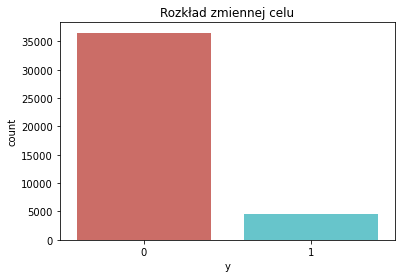

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x= 'y', data=data_final,  palette='hls')
plt.title('Rozkład zmiennej celu')
plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\1_target_distribution.png", format="png" , dpi=600, facecolor="White")
plt.show()


##### SMOTE
Więcej informacji można znaleźć na stronie https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn


In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#from sklearn.base import _ClassNamePrefixFeaturesOutMixin

X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

os = SMOTE(random_state=128262)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=128262)
columns = X_train.columns

os_data_X, os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])


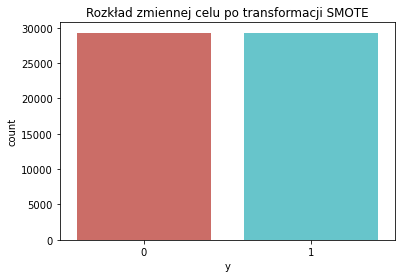

In [8]:
sns.countplot(x= 'y', data=os_data_y,  palette='hls')
plt.title('Rozkład zmiennej celu po transformacji SMOTE')
plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\2_target_distribution_SMOTE.png", format="png" , dpi=600, facecolor="White")
plt.show()

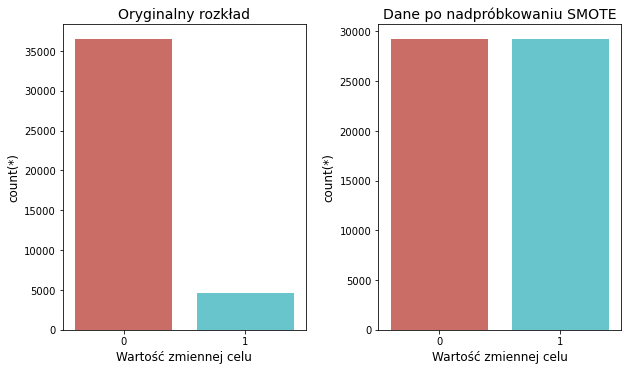

In [24]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10,9/16*10))
gs = gridspec.GridSpec(nrows=1, 
                       ncols=2, 
                       figure=fig,
                       hspace=1,
                       wspace=0.3
                      )
ax1 = fig.add_subplot(gs[0])
ax1 = sns.countplot(x= 'y', data=data_final,  palette='hls')
ax1.set_xlabel('Wartość zmiennej celu', fontsize=12)
ax1.set_ylabel('count(*)', fontsize=12)
ax1.set_title('Oryginalny rozkład', fontsize=14)

ax1 = fig.add_subplot(gs[1])
ax2 = sns.countplot(x= 'y', data=os_data_y,  palette='hls')
ax2.set_xlabel('Wartość zmiennej celu', fontsize=12)
ax2.set_ylabel('count(*)', fontsize=12)
ax2.set_title('Dane po nadpróbkowaniu SMOTE', fontsize=14)

plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\3_target_distribution_both.png", format="png" , dpi=600, facecolor="White")



Dokładność dla zbioru walidacyjnego: 0.8880
Dokładność dla zbioru traningowego oryginalnego: 0.9011
Dokładność dla zbioru traningowego zbalansowanego: 0.9353
Wartość parametru Gini na zbiorze walidacyjnym to: 0.5511
Wartość parametru Gini na zbiorze treningowym to: 0.6297
Wartość parametru Gini na zbiorze zbalansowanym to: 0.9490

ROC Curve

Confusion Matrix


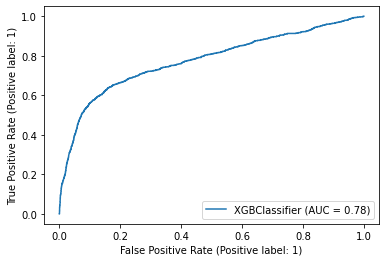

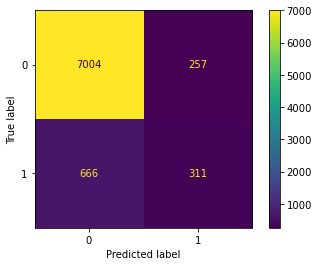

In [28]:
# wyjściowy model względem którego będziemy 
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

xgb_clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            objective='binary:logistic',
                            booster='gbtree',
                            n_jobs=-1,
                            random_state=1)

# uczymy model, korzystamy z API sklearn
xgb_clf.fit(os_data_X, os_data_y)

# przeliczamy skoringi na zbiorze testowym aby sprawdzić jakość modelu w rozumieniu interesujących mnie miar
y_hat = xgb_clf.predict(X_test)

auc_val = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
auc_train = roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1])
auc_train_os = roc_auc_score(os_data_y, xgb_clf.predict_proba(os_data_X)[:, 1])

print("Dokładność dla zbioru walidacyjnego: {0:.4f}".format(accuracy_score(y_test, y_hat)))
print("Dokładność dla zbioru traningowego oryginalnego: {0:.4f}".format(accuracy_score(y_train, xgb_clf.predict(X_train))))
print("Dokładność dla zbioru traningowego zbalansowanego: {0:.4f}".format(accuracy_score(os_data_y, xgb_clf.predict(os_data_X))))

print("Wartość parametru Gini na zbiorze walidacyjnym to: {0:.4f}".format(2*auc_val-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze treningowym to: {0:.4f}".format(2*auc_train-1)) # Gini = 2*AUC-1
print("Wartość parametru Gini na zbiorze zbalansowanym to: {0:.4f}".format(2*auc_train_os-1)) # Gini = 2*AUC-1

print("\nROC Curve")
print(RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test))
#RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
#plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\2_target_distribution_SMOTE.png", format="png" , dpi=600, facecolor="White")
#plt.savefig(r"E:\page_ds\XGBoost_step_by_step\foto\2_ROC_cur_clf.png", format="png" , dpi=300, facecolor="White")

print("\nConfusion Matrix")
cm = confusion_matrix(y_test, y_hat, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=xgb_clf.classes_)
print(disp.plot())


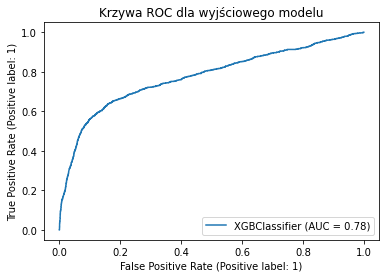

In [29]:
RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test)
plt.title('Krzywa ROC dla wyjściowego modelu')
plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\3_ROC_first_modell.png", format="png" , dpi=600, facecolor="White")


#### Teraz naryzusjemy krzywą Lorenza dla naszego modelu 

In [30]:
# sklejamy DataFrame składający się z naszych skoringów oraz targetu, działam na zbiorze treningowym
GiniSet = pd.DataFrame(list(zip(xgb_clf.predict_proba(X_train)[:,1].tolist(),\
                                y_train['y'].tolist())), columns=['proba', 'target'] )
# potrzebujemy posortowanego zboru względem naszego skoringu
GiniSet.sort_values(by = ['proba'], inplace=True)
# dla uprostrzenia korzystam z indeksu
GiniSet.reset_index(inplace=True)
GiniSet['index'] =  GiniSet.index

# wartości skumulowane 
max_idx = np.max(GiniSet['index'])
GiniSet['index'] = GiniSet['index']/max_idx 

sum_target = np.sum(GiniSet['target'])
GiniSet['target'] = np.cumsum(GiniSet['target'])/sum_target

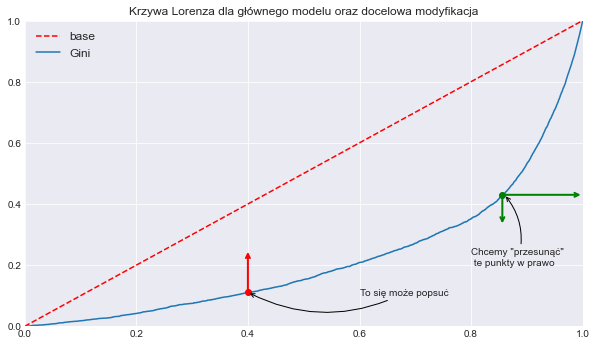

In [52]:
import seaborn as sns
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(10,9/16*10))
plt.plot([0, 1.0], [0, 1.0],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot(GiniSet['index'].tolist(), GiniSet['target'].tolist(), )
ax.legend(['base', 'Gini'], facecolor='w', fontsize = 'large')

ax.annotate('Chcemy "przesunąć" \n te punkty w prawo', xy=(0.86,0.43), xytext=(0.8,0.2), arrowprops=\
            dict(arrowstyle='->',  linewidth=1, connectionstyle='arc3, rad=0.25'))

ax.annotate('', xy=(1.0,0.43), xytext=(0.856,0.43), arrowprops=dict(arrowstyle='->', linewidth=2, color='green'))
ax.annotate('', xy=(0.856,0.33), xytext=(0.856,0.43), arrowprops=dict(arrowstyle='->', linewidth=2, color='green'))

ax.plot(0.4, 0.111, c='red', marker='o')
ax.plot(0.856,0.43, c='green', marker='o')

ax.annotate('To się może popsuć', xy=(0.4,0.111), xytext=(0.6,0.1), arrowprops=\
            dict(arrowstyle='->',  linewidth=1, connectionstyle='arc3, rad=-0.25'))

ax.annotate('', xy=(0.4, 0.25), xytext=(0.4,0.111), arrowprops=dict(arrowstyle='->', linewidth=2, color='red'))

plt.title('Krzywa Lorenza dla głównego modelu oraz docelowa modyfikacja')
plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\4_Krzywa_Lorenza.png", format="png" , dpi=600, facecolor="White")
plt.show()

Idea jest taka, żeby wykorzystać algorytm optuny do zaproponowania takich hiperparametrów, które przybliżą właśnie wskazany punkt możliwe kosztem czerwonego. Aby to uzyskać musimy wbrać % populacji, który chcemy "przykleić" do osi y oraz funkcję, którą będziemy w związku z tym optymalizować. 

In [32]:
# najpierw definiujemy funkcję, która będzie zwracać wartość punktu na wykresie Giniego- celem będzie 
# jej minimalizacja w zadanym punkcie X (oznaczający jaką część populacji np. chcemy wysłać do kampanii) 
def customize_gini_curve(X_cut, y_proba, y):
    if X_cut >= 1 or X_cut <= 0:
        X_cut = 0.5
    GiniSet_ = pd.DataFrame(list(zip(y_proba,  y)), columns=['proba', 'target'] )
    GiniSet_.sort_values(by = ['proba'], inplace=True)
    GiniSet_.reset_index(inplace=True)
    max_idx = np.max(GiniSet_['index'])
    GiniSet_['index'] = GiniSet_['index']/max_idx 
    sum_target = np.sum(GiniSet_['target'])
    GiniSet_['target'] = np.cumsum(GiniSet_['target'])/sum_target
    return GiniSet_.iloc[int(np.floor(GiniSet_.shape[0]*X_cut)), 2]

In [33]:
import optuna

def objective(trial):
    # definiujemy zbiór treningowy ustawiając ten sam random state dla powtarzalności losowania
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=128262)
    os_data_X, os_data_y=os.fit_resample(X_train, y_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

    #API niekompaktybilne z scikit
    dtrain = xgb.DMatrix(X_train, label = y_train)
    dtest = xgb.DMatrix(X_test, label = y_test)

    #https://xgboost.readthedocs.io/en/stable/parameter.html
    param = {
            #"silent": 1,
             "objective": "binary:logistic",
             "eval_metric": "auc",
             "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
             "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
             "alpha": trial.suggest_loguniform("alpha",1e-8, 1.0),
            }
    
    # parametry dodatkowe dla rodzajów boostera (jest jeszcze gblinear, którego tutaj nie umieszczałem)
    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1,9)
        param["eta"] = trial.suggest_loguniform("eta", 1e-8, 1.0)
        param["gamma"] = trial.suggest_loguniform("gamma",1e-8, 1.0)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise","lossguide"])
    
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform","weighted"])
        param["normalize_type"]= trial.suggest_categorical("normalize_type", ["tree","forest"])
        param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-8, 1.0)
        param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-8, 1.0)

    # dodanie elementów wczesnego przerwania Triala w sytuacji gdy jest nierokujący
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain,  evals=[(dtest, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dtest)

    preds = bst.predict(dtest)
    gini_point = customize_gini_curve(0.8, list(preds), list(y_test['y']))
    return gini_point

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials = 200)
print(study.best_trial)

In [41]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	booster: gbtree
	lambda: 1.013929288381433e-08
	alpha: 4.7837327152287665e-08
	max_depth: 2
	eta: 0.9924120250613618
	gamma: 1.1252587624044091e-07
	grow_policy: lossguide


Mamy już docelowy model, możemy porównać krzywe Giniego obu modeli. 

In [42]:
xgb_clf_opt = xgb.XGBClassifier(max_depth=2,
                                n_estimators=100,
                                reg_lambda = 1.013929288381433e-08,
                                alpha = 4.7837327152287665e-08,
                                eta = 0.9924120250613618,
                                grow_policy = 'lossguide',
                                gamma = 1.1252587624044091e-07,
                                booster='gbtree',
                                n_jobs=-1,
                                random_state=1)

# uczymy model, korzystamy z API sklearn
xgb_clf_opt.fit(os_data_X, os_data_y)

XGBClassifier(alpha=4.7837327152287665e-08, base_score=0.5, booster='gbtree',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.9924120250613618,
              eval_metric=None, gamma=1.1252587624044091e-07, gpu_id=-1,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints='', learning_rate=0.992412031,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=1, ...)

In [45]:
xgb_clf_opt = xgb.XGBClassifier(max_depth=3,
                                n_estimators=100,
                                reg_lambda = 2.4811635189491823e-07,
                                alpha = 0.005170148193729972,
                                eta = 0.8611647894369349,
                                gamma = 0.036256117623736595,
                                sample_type = 'weighted',
                                normalize_type = 'forest',
                                rate_drop = 5.513401203501515e-06,
                                skip_drop = 1.4932665117015075e-08,
                                objective='binary:logistic',
                                booster='dart',
                                n_jobs=-1,
                                random_state=1)

# uczymy model, korzystamy z API sklearn
xgb_clf_opt.fit(os_data_X, os_data_y)

XGBClassifier(alpha=0.005170148193729972, base_score=0.5, booster='dart',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.8611647894369349,
              eval_metric=None, gamma=0.036256117623736595, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.861164808,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              normalize_type='forest', num_parallel_tree=1, predictor='auto', ...)

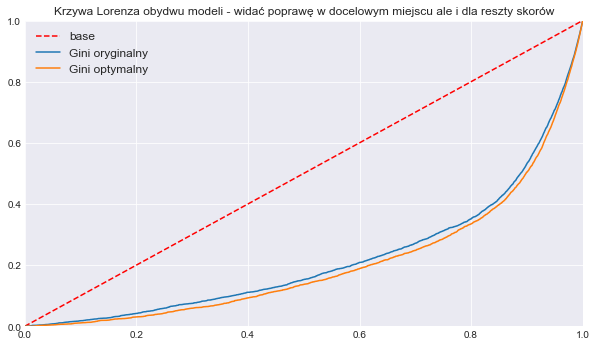

In [51]:
GiniSetOpt = pd.DataFrame(list(zip(xgb_clf_opt.predict_proba(X_train)[:,1].tolist(),\
                                y_train['y'].tolist())), columns=['proba', 'target'] )

GiniSetOpt.sort_values(by = ['proba'], inplace=True)
GiniSetOpt.reset_index(inplace=True)

GiniSetOpt['index'] =  GiniSetOpt.index

max_idx_opt = np.max(GiniSetOpt['index'])
GiniSetOpt['index'] = GiniSetOpt['index']/max_idx_opt 

sum_target_opt = np.sum(GiniSetOpt['target'])
GiniSetOpt['target'] = np.cumsum(GiniSetOpt['target'])/sum_target_opt

# i ostateczny wykres z obydwoma wykresami Giniego
import seaborn as sns
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots(figsize=(10,9/16*10))
plt.plot([0, 1.0], [0, 1.0],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot(GiniSet['index'].tolist(), GiniSet['target'].tolist() )
plt.plot(GiniSetOpt['index'].tolist(), GiniSetOpt['target'].tolist() )

ax.legend(['base', 'Gini oryginalny', 'Gini optymalny'], facecolor='w', fontsize = 'large')

plt.title('Krzywa Lorenza obydwu modeli - widać poprawę w docelowym miejscu ale i dla reszty skorów')
plt.savefig(r"E:\page_ds\tweaking_the_response_results\foto\5_Porownanie_Krzywych_Lorenza.png", format="png" , dpi=600, facecolor="White")
plt.show()

In [50]:
print("wielkość pierwotna punktu na krzywej Lorenza dla 80% populacji to: {0:.4f}".format\
      (customize_gini_curve(0.8, GiniSet['index'].tolist(), GiniSet['target'].tolist())))
print("wielkość zoptymalizowanego punktu na krzywej Lorenza dla 80% populacji to: {0:.4f}".format\
      (customize_gini_curve(0.8, GiniSetOpt['index'].tolist(), GiniSetOpt['target'].tolist())))

wielkość pierwotna punktu na krzywej Lorenza dla 80% populacji to: 0.4766
wielkość zoptymalizowanego punktu na krzywej Lorenza dla 80% populacji to: 0.4547
